In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Batch Normalization
# Author: Tracy Tao
# Date: 2022/04/12
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

- BN可持续加速深层网络的收敛速度.
- 为什么需要批量规范化层呢？
    1. 数据预处理:标准化, 将参数的量级统一
    2. 模型参数的变化和偏移阻碍收敛
    3. 复杂深度网络容易过拟合，需要正则化
- 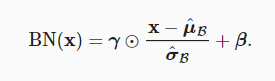
- 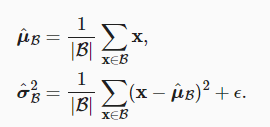
---
- 批量规范层
    1. FC：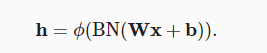
    2. Conv：在每个输出通道的m * p * q个元素上同时执行每个批量规范化.在计算平均值和方差时，我们会收集所有空间位置的值，然后**在给定通道内应用相同的均值和方差**，以便在每个空间位置对值进行规范化。
---
- 预测过程中的批量规范化
    1. 将训练好的模型用于预测时，不需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差
    2. 需要使用模型对逐个样本进行预测，通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用

In [3]:
def BN(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 判断是训练模式还是预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps) # 在预测模式CIA，使用移动平均，考虑噪声
    else:
        assert len(X.shape) in (2,4) # 限定X的维度范围
        if len(X.shape) == 2: # 如果是FC，就计算特征维度上的均值和方差
            mean = X.mean(dim = 0) # 如果是FC，就计算特征维度上的均值
            var = ((X - mean) **2).mean(dim=0) # 如果是FC，就计算特征维度上的方差
        else: # 如果是2维卷积层
            mean = X.mean(dim=(0, 2, 3), keepdim= True) # 计算axis=1的上的均值
            var = ((X- mean) **2).mean(dim= (0,2,3), keepdim= True)
        X_hat = (X -mean) / torch.sqrt(var + eps) # 训练模式
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y= gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [9]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        '''
        :param num_features: 完全连接层的输出数量或卷积层的输出通道数
        :param num_dims: 2表示完全连接层，4表示卷积层
        '''
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape)) # 拉伸参数，初始化为1
        self.beta = nn.Parameter(torch.zeros(shape)) # 偏移参数，初始化为0
        self.moving_mean = torch.zeros(shape) # 非参数：移动平均，初始化为0
        self.moving_var = torch.ones(shape) # 非参数：移动方差，初始化为1
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = BN(X,
                                                  self.gamma,
                                                  self.beta,
                                                  self.moving_mean,
                                                  self.moving_var,
                                                  eps = 1e-5,
                                                  momentum = 0.9)
        return Y

In [12]:
# LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [13]:
# DL module
net = nn.Sequential(nn.Conv2d(1,6, kernel_size = 5), nn.BatchNorm2d(6), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2),
                    nn.Conv2d(1,6, kernel_size = 5), nn.BatchNorm2d(16), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size = 2, stride = 2), nn.Flatten(),
                    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
                    nn.Linear(84, 10))
                    